In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
import os
import json
import torch
import yaml
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry
from plane_nerf.inerf_utils import get_origin

In [21]:
DATA_PATH = "/workspace/plane-nerf/data/jackal_tag_training_data_1"
MODEL_CHOICE = "default"
DEVICE = "cuda:0"
SAM_CHECKPOINT = "/stored_data/sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_CHOICE](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
sam = SamPredictor(sam)

if not os.path.exists(DATA_PATH + "/images"):
    os.makedirs(DATA_PATH + "/images")
if not os.path.exists(DATA_PATH + "/masks"):
    os.makedirs(DATA_PATH + "/masks")

#Open transform file
with open(os.path.join(DATA_PATH, 'transforms.json'), 'r') as f:
    transform = json.load(f)

In [22]:
intrinsic = np.zeros((3,4))
intrinsic[0,0] = transform["fl_x"]
intrinsic[1,1] = transform["fl_y"]
intrinsic[0,2] = transform["cx"]
intrinsic[1,2] = transform["cy"]
intrinsic[2,2] = 1

In [23]:
new_frames = []

for i in range(len(transform["frames"])):
    img_path = os.path.join(DATA_PATH, transform["frames"][i]["file_path"])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pose = transform["frames"][i]["transform_matrix"]
    pose = np.array(pose).reshape(4,4)
    inverse = np.linalg.inv(pose)

    #Rotate about x axis by 180 degrees
    rot = np.eye(4)
    rot[1,1] = -1
    rot[2,2] = -1
    inv_transform = rot @ inverse
    
    plane_index = intrinsic @ inv_transform
    plane_index = plane_index[:,3] #z=0
    origin_coord = plane_index[:2]/plane_index[2]
    origin_coord = origin_coord.reshape(1,2)

    sam.set_image(image)
    masks, _, _ = sam.predict(
        point_coords=origin_coord,
        point_labels=np.array([1]),
        multimask_output=True,
    )

    #Save mask
    mask = masks[-1]
    mask = mask.astype(np.uint8)
    mask = mask * 255
    mask = Image.fromarray(mask)
    mask_path = os.path.join(DATA_PATH, transform["frames"][i]["mask_path"])
    
    #Save mask to file
    mask.save(mask_path)


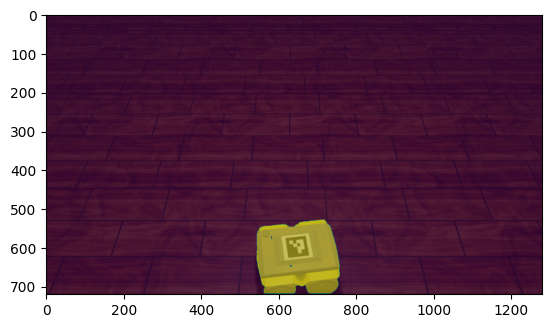

In [24]:
#Show mask over image
plt.imshow(image)
plt.imshow(masks[-1], alpha=0.5)
plt.show()